In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import genpareto
from math import sqrt
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from helper import series_to_supervised
from model.cnn import cnn_4layer
from model.mlp import mlp_layer

2024-01-11 22:16:21.839045: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
# import random

# random.seed(10)
# print(random.random())

In [4]:
data = pd.read_csv("../../data/pollution.csv", index_col=0)
data.fillna(0, inplace=True)
data.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,NE,NW,SE,cv
date,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


### Preprocess

In [5]:
values = data.values

# specify the number of lag hours
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)
print("reframed.shape:", reframed.shape)

reframed.shape: (43717, 924)


In [6]:
# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 0
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (30601, 792) (30601, 12) (6558, 792) (6558, 12) (6558, 792) (6558, 12)


In [7]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (30601, 72, 11) (30601, 12) (6558, 72, 11) (6558, 12) (6558, 72, 11) (6558, 12)


### PM threshold

In [40]:
train_X_pm = train_X[:, 0, feature_idx]
print(train_X_pm.shape)

val_X_pm = val_X[:, 0, feature_idx]
print(val_X_pm.shape)

test_X_pm = test_X[:, 0, feature_idx]
print(test_X_pm.shape)

(30601,)
(6558,)
(6558,)


In [41]:
percentile = 90

merged_array = np.concatenate((train_X_pm, val_X_pm, test_X_pm))

percentile_pm = np.percentile(merged_array, percentile)

print("{}th Percentile of Daily Rain:".format(percentile), percentile_pm)

90th Percentile of Daily Rain: 0.253448275862069


In [42]:
len(train_X_pm[train_X_pm > percentile_pm])

2116

In [43]:
# Extract excesses over the threshold from the heavy pm data only
excesses = np.abs(train_X_pm[train_X_pm > percentile_pm] - percentile_pm)
excesses.shape

(2116,)

In [44]:
# Fit Generalized Pareto Distribution (GPD) to excesses - returns shape (c), loc, scale for fitted distribution
c, loc, scale = genpareto.fit(excesses)


# Define a function to calculate weights based on the survival function of the GPD
def calculate_weights(pm, c, loc, scale, threshold):
    """
    survival function, also known as the complementary cumulative distribution function (CCDF), 
    is a function that gives the probability that a random variable X is greater than a certain value x
    """
    # Weights are the inverse of the survival function
    weights = np.where(pm > threshold, 
                       1.0 / (1 - genpareto.cdf(pm-threshold, c, loc=loc, scale=scale)),
#                        1.0 / (1 - genpareto.cdf(threshold - loc, c, loc=loc, scale=scale)),
                       1.5
                      )  # Assign a default weight of 1 for non-extreme events

    # Normalize weights (optional, for stability in training)
#     weights /= np.max(weights)
#     weights = (weights - np.min(weights)) / (np.max(weights) - np.min(weights)) + 0.1
#     weights = weights + 0.1
#     weights = np.exp(weights)
    weights /= np.sum(weights)
    return weights

# Calculate weights for each sample in your dataset
weights = calculate_weights(train_X_pm, c, loc, scale, percentile_pm)
weights.shape

(30601,)

(array([3.0585e+04, 5.0000e+00, 4.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.37780959e-05, 3.19322516e-03, 6.37267223e-03, 9.55211930e-03,
        1.27315664e-02, 1.59110134e-02, 1.90904605e-02, 2.22699076e-02,
        2.54493546e-02, 2.86288017e-02, 3.18082488e-02, 3.49876959e-02,
        3.81671429e-02, 4.13465900e-02, 4.45260371e-02, 4.77054841e-02,
        5.08849312e-02, 5.40643783e-02, 5.72438253e-02, 6.04232724e-02,
        6.36027195e-02]),
 <BarContainer object of 20 artists>)

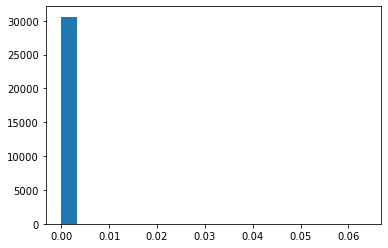

In [46]:
plt.hist(weights, bins=20)

In [47]:
np.save('sample_weights_pm_EVT.npy', weights)

### Model

In [48]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0.0
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 1000
BATCH = 512
opt_num = k
input_shape = train_X.shape[1:]

In [49]:
model = mlp_layer(input_shape=input_shape,
                   mlp_unit1=mlp_unit1,
                   mlp_unit2=mlp_unit2,
                   mlp_unit3=mlp_unit3,
                   mlp_unit4=mlp_unit4,
                   mlp_unit5=mlp_unit5,
                   mlp_unit6=mlp_unit6,
                   mlp_unit7=mlp_unit7,
                   mlp_unit8=mlp_unit8,
                   dropout=dropout,
                   masked_value=-1,
                   opt_num=opt_num
                  )
# model.summary()

In [50]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae']
             )


es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models/pm_all_weighted_EVT_95.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True
                    )


model.fit(train_X, train_y,
          validation_data=(val_X, val_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc],
          sample_weight=weights
         )

Epoch 1/1000
60/60 - 2s - loss: 4.9399e-07 - mae: 0.0860 - val_loss: 0.0303 - val_mae: 0.1140

Epoch 00001: val_mae improved from inf to 0.11399, saving model to ../../saved_models/pm_all_weighted_EVT_95.h5
Epoch 2/1000
60/60 - 1s - loss: 2.9438e-07 - mae: 0.0722 - val_loss: 0.0243 - val_mae: 0.1051

Epoch 00002: val_mae improved from 0.11399 to 0.10515, saving model to ../../saved_models/pm_all_weighted_EVT_95.h5
Epoch 3/1000
60/60 - 1s - loss: 2.7567e-07 - mae: 0.0719 - val_loss: 0.0241 - val_mae: 0.1046

Epoch 00003: val_mae improved from 0.10515 to 0.10456, saving model to ../../saved_models/pm_all_weighted_EVT_95.h5
Epoch 4/1000
60/60 - 1s - loss: 2.7150e-07 - mae: 0.0716 - val_loss: 0.0237 - val_mae: 0.1035

Epoch 00004: val_mae improved from 0.10456 to 0.10345, saving model to ../../saved_models/pm_all_weighted_EVT_95.h5
Epoch 5/1000
60/60 - 1s - loss: 2.6899e-07 - mae: 0.0711 - val_loss: 0.0235 - val_mae: 0.1028

Epoch 00005: val_mae improved from 0.10345 to 0.10278, saving mod


Epoch 00042: val_mae improved from 0.07165 to 0.07162, saving model to ../../saved_models/pm_all_weighted_EVT_95.h5
Epoch 43/1000
60/60 - 1s - loss: 1.3249e-07 - mae: 0.0474 - val_loss: 0.0112 - val_mae: 0.0716

Epoch 00043: val_mae improved from 0.07162 to 0.07158, saving model to ../../saved_models/pm_all_weighted_EVT_95.h5
Epoch 44/1000
60/60 - 1s - loss: 1.3059e-07 - mae: 0.0471 - val_loss: 0.0118 - val_mae: 0.0737

Epoch 00044: val_mae did not improve from 0.07158
Epoch 45/1000
60/60 - 1s - loss: 1.3784e-07 - mae: 0.0484 - val_loss: 0.0116 - val_mae: 0.0728

Epoch 00045: val_mae did not improve from 0.07158
Epoch 46/1000
60/60 - 1s - loss: 1.3033e-07 - mae: 0.0473 - val_loss: 0.0115 - val_mae: 0.0724

Epoch 00046: val_mae did not improve from 0.07158
Epoch 47/1000
60/60 - 1s - loss: 1.2923e-07 - mae: 0.0467 - val_loss: 0.0107 - val_mae: 0.0698

Epoch 00047: val_mae improved from 0.07158 to 0.06982, saving model to ../../saved_models/pm_all_weighted_EVT_95.h5
Epoch 48/1000
60/60 -

60/60 - 1s - loss: 1.0947e-07 - mae: 0.0440 - val_loss: 0.0094 - val_mae: 0.0656

Epoch 00091: val_mae improved from 0.06567 to 0.06558, saving model to ../../saved_models/pm_all_weighted_EVT_95.h5
Epoch 92/1000
60/60 - 1s - loss: 1.0778e-07 - mae: 0.0434 - val_loss: 0.0099 - val_mae: 0.0667

Epoch 00092: val_mae did not improve from 0.06558
Epoch 93/1000
60/60 - 1s - loss: 1.0718e-07 - mae: 0.0432 - val_loss: 0.0095 - val_mae: 0.0651

Epoch 00093: val_mae improved from 0.06558 to 0.06510, saving model to ../../saved_models/pm_all_weighted_EVT_95.h5
Epoch 94/1000
60/60 - 1s - loss: 1.0700e-07 - mae: 0.0433 - val_loss: 0.0101 - val_mae: 0.0672

Epoch 00094: val_mae did not improve from 0.06510
Epoch 95/1000
60/60 - 1s - loss: 1.0830e-07 - mae: 0.0436 - val_loss: 0.0097 - val_mae: 0.0662

Epoch 00095: val_mae did not improve from 0.06510
Epoch 96/1000
60/60 - 1s - loss: 1.0658e-07 - mae: 0.0430 - val_loss: 0.0095 - val_mae: 0.0651

Epoch 00096: val_mae improved from 0.06510 to 0.06509, s


Epoch 00141: val_mae did not improve from 0.06321
Epoch 142/1000
60/60 - 1s - loss: 1.0022e-07 - mae: 0.0421 - val_loss: 0.0091 - val_mae: 0.0633

Epoch 00142: val_mae did not improve from 0.06321
Epoch 143/1000
60/60 - 1s - loss: 9.8716e-08 - mae: 0.0417 - val_loss: 0.0092 - val_mae: 0.0636

Epoch 00143: val_mae did not improve from 0.06321
Epoch 144/1000
60/60 - 1s - loss: 1.0201e-07 - mae: 0.0427 - val_loss: 0.0097 - val_mae: 0.0656

Epoch 00144: val_mae did not improve from 0.06321
Epoch 145/1000
60/60 - 1s - loss: 9.9818e-08 - mae: 0.0422 - val_loss: 0.0091 - val_mae: 0.0633

Epoch 00145: val_mae did not improve from 0.06321
Epoch 146/1000
60/60 - 1s - loss: 1.0134e-07 - mae: 0.0425 - val_loss: 0.0091 - val_mae: 0.0637

Epoch 00146: val_mae did not improve from 0.06321
Epoch 147/1000
60/60 - 1s - loss: 9.9657e-08 - mae: 0.0419 - val_loss: 0.0092 - val_mae: 0.0639

Epoch 00147: val_mae did not improve from 0.06321
Epoch 148/1000
60/60 - 1s - loss: 9.9785e-08 - mae: 0.0422 - val_lo

60/60 - 1s - loss: 9.7375e-08 - mae: 0.0417 - val_loss: 0.0088 - val_mae: 0.0633

Epoch 00195: val_mae did not improve from 0.06223
Epoch 196/1000
60/60 - 1s - loss: 9.6758e-08 - mae: 0.0417 - val_loss: 0.0088 - val_mae: 0.0623

Epoch 00196: val_mae did not improve from 0.06223
Epoch 197/1000
60/60 - 1s - loss: 9.5087e-08 - mae: 0.0411 - val_loss: 0.0089 - val_mae: 0.0625

Epoch 00197: val_mae did not improve from 0.06223
Epoch 198/1000
60/60 - 1s - loss: 9.4102e-08 - mae: 0.0410 - val_loss: 0.0089 - val_mae: 0.0625

Epoch 00198: val_mae did not improve from 0.06223
Epoch 199/1000
60/60 - 1s - loss: 9.5255e-08 - mae: 0.0412 - val_loss: 0.0090 - val_mae: 0.0627

Epoch 00199: val_mae did not improve from 0.06223
Epoch 200/1000
60/60 - 1s - loss: 9.4169e-08 - mae: 0.0409 - val_loss: 0.0089 - val_mae: 0.0627

Epoch 00200: val_mae did not improve from 0.06223
Epoch 201/1000
60/60 - 1s - loss: 9.4602e-08 - mae: 0.0410 - val_loss: 0.0090 - val_mae: 0.0627

Epoch 00201: val_mae did not improve


Epoch 00249: val_mae did not improve from 0.06183
Epoch 250/1000
60/60 - 1s - loss: 9.0598e-08 - mae: 0.0403 - val_loss: 0.0088 - val_mae: 0.0620

Epoch 00250: val_mae did not improve from 0.06183
Epoch 251/1000
60/60 - 1s - loss: 9.1140e-08 - mae: 0.0404 - val_loss: 0.0089 - val_mae: 0.0628

Epoch 00251: val_mae did not improve from 0.06183
Epoch 252/1000
60/60 - 1s - loss: 9.1732e-08 - mae: 0.0407 - val_loss: 0.0089 - val_mae: 0.0623

Epoch 00252: val_mae did not improve from 0.06183
Epoch 253/1000
60/60 - 1s - loss: 9.1240e-08 - mae: 0.0407 - val_loss: 0.0087 - val_mae: 0.0617

Epoch 00253: val_mae improved from 0.06183 to 0.06167, saving model to ../../saved_models/pm_all_weighted_EVT_95.h5
Epoch 254/1000
60/60 - 1s - loss: 9.2143e-08 - mae: 0.0407 - val_loss: 0.0087 - val_mae: 0.0621

Epoch 00254: val_mae did not improve from 0.06167
Epoch 255/1000
60/60 - 1s - loss: 9.0435e-08 - mae: 0.0403 - val_loss: 0.0088 - val_mae: 0.0620

Epoch 00255: val_mae did not improve from 0.06167
E


Epoch 00303: val_mae did not improve from 0.06141
Epoch 304/1000
60/60 - 1s - loss: 8.8046e-08 - mae: 0.0399 - val_loss: 0.0086 - val_mae: 0.0618

Epoch 00304: val_mae did not improve from 0.06141
Epoch 305/1000
60/60 - 1s - loss: 8.7853e-08 - mae: 0.0400 - val_loss: 0.0087 - val_mae: 0.0618

Epoch 00305: val_mae did not improve from 0.06141
Epoch 306/1000
60/60 - 1s - loss: 8.7503e-08 - mae: 0.0397 - val_loss: 0.0087 - val_mae: 0.0616

Epoch 00306: val_mae did not improve from 0.06141
Epoch 307/1000
60/60 - 1s - loss: 8.7559e-08 - mae: 0.0399 - val_loss: 0.0088 - val_mae: 0.0622

Epoch 00307: val_mae did not improve from 0.06141
Epoch 308/1000
60/60 - 1s - loss: 8.7277e-08 - mae: 0.0397 - val_loss: 0.0088 - val_mae: 0.0620

Epoch 00308: val_mae did not improve from 0.06141
Epoch 309/1000
60/60 - 1s - loss: 8.7529e-08 - mae: 0.0398 - val_loss: 0.0087 - val_mae: 0.0616

Epoch 00309: val_mae did not improve from 0.06141
Epoch 310/1000
60/60 - 1s - loss: 8.8230e-08 - mae: 0.0402 - val_lo


Epoch 00358: val_mae did not improve from 0.06092
Epoch 359/1000
60/60 - 1s - loss: 9.3280e-08 - mae: 0.0423 - val_loss: 0.0090 - val_mae: 0.0629

Epoch 00359: val_mae did not improve from 0.06092
Epoch 360/1000
60/60 - 1s - loss: 9.0071e-08 - mae: 0.0409 - val_loss: 0.0087 - val_mae: 0.0617

Epoch 00360: val_mae did not improve from 0.06092
Epoch 361/1000
60/60 - 1s - loss: 8.5523e-08 - mae: 0.0396 - val_loss: 0.0088 - val_mae: 0.0621

Epoch 00361: val_mae did not improve from 0.06092
Epoch 362/1000
60/60 - 1s - loss: 8.5086e-08 - mae: 0.0394 - val_loss: 0.0086 - val_mae: 0.0614

Epoch 00362: val_mae did not improve from 0.06092
Epoch 363/1000
60/60 - 1s - loss: 8.5148e-08 - mae: 0.0394 - val_loss: 0.0086 - val_mae: 0.0614

Epoch 00363: val_mae did not improve from 0.06092
Epoch 364/1000
60/60 - 1s - loss: 8.4590e-08 - mae: 0.0393 - val_loss: 0.0087 - val_mae: 0.0617

Epoch 00364: val_mae did not improve from 0.06092
Epoch 365/1000
60/60 - 1s - loss: 8.4511e-08 - mae: 0.0393 - val_lo

60/60 - 1s - loss: 8.6192e-08 - mae: 0.0401 - val_loss: 0.0093 - val_mae: 0.0655

Epoch 00414: val_mae did not improve from 0.06061
Epoch 415/1000
60/60 - 1s - loss: 9.3178e-08 - mae: 0.0420 - val_loss: 0.0086 - val_mae: 0.0616

Epoch 00415: val_mae did not improve from 0.06061
Epoch 416/1000
60/60 - 1s - loss: 8.7447e-08 - mae: 0.0402 - val_loss: 0.0088 - val_mae: 0.0621

Epoch 00416: val_mae did not improve from 0.06061
Epoch 417/1000
60/60 - 1s - loss: 8.3240e-08 - mae: 0.0392 - val_loss: 0.0087 - val_mae: 0.0617

Epoch 00417: val_mae did not improve from 0.06061
Epoch 418/1000
60/60 - 1s - loss: 8.4460e-08 - mae: 0.0397 - val_loss: 0.0088 - val_mae: 0.0621

Epoch 00418: val_mae did not improve from 0.06061
Epoch 419/1000
60/60 - 1s - loss: 8.2578e-08 - mae: 0.0390 - val_loss: 0.0087 - val_mae: 0.0615

Epoch 00419: val_mae did not improve from 0.06061
Epoch 420/1000
60/60 - 1s - loss: 8.2937e-08 - mae: 0.0392 - val_loss: 0.0089 - val_mae: 0.0624

Epoch 00420: val_mae did not improve

60/60 - 1s - loss: 8.2399e-08 - mae: 0.0390 - val_loss: 0.0087 - val_mae: 0.0616

Epoch 00470: val_mae did not improve from 0.06061
Epoch 471/1000
60/60 - 1s - loss: 8.1352e-08 - mae: 0.0389 - val_loss: 0.0086 - val_mae: 0.0615

Epoch 00471: val_mae did not improve from 0.06061
Epoch 472/1000
60/60 - 1s - loss: 8.0921e-08 - mae: 0.0387 - val_loss: 0.0087 - val_mae: 0.0615

Epoch 00472: val_mae did not improve from 0.06061
Epoch 473/1000
60/60 - 1s - loss: 8.1068e-08 - mae: 0.0389 - val_loss: 0.0086 - val_mae: 0.0614

Epoch 00473: val_mae did not improve from 0.06061
Epoch 474/1000
60/60 - 1s - loss: 8.0906e-08 - mae: 0.0388 - val_loss: 0.0087 - val_mae: 0.0617

Epoch 00474: val_mae did not improve from 0.06061
Epoch 475/1000
60/60 - 1s - loss: 8.2610e-08 - mae: 0.0394 - val_loss: 0.0088 - val_mae: 0.0621

Epoch 00475: val_mae did not improve from 0.06061
Epoch 476/1000
60/60 - 1s - loss: 8.2138e-08 - mae: 0.0391 - val_loss: 0.0086 - val_mae: 0.0615

Epoch 00476: val_mae did not improve

60/60 - 1s - loss: 8.0385e-08 - mae: 0.0389 - val_loss: 0.0088 - val_mae: 0.0624

Epoch 00526: val_mae did not improve from 0.06061
Epoch 527/1000
60/60 - 1s - loss: 8.2768e-08 - mae: 0.0393 - val_loss: 0.0088 - val_mae: 0.0631

Epoch 00527: val_mae did not improve from 0.06061
Epoch 528/1000
60/60 - 1s - loss: 1.1174e-07 - mae: 0.0450 - val_loss: 0.0092 - val_mae: 0.0650

Epoch 00528: val_mae did not improve from 0.06061
Epoch 529/1000
60/60 - 1s - loss: 8.6670e-08 - mae: 0.0402 - val_loss: 0.0086 - val_mae: 0.0621

Epoch 00529: val_mae did not improve from 0.06061
Epoch 530/1000
60/60 - 1s - loss: 8.2261e-08 - mae: 0.0393 - val_loss: 0.0087 - val_mae: 0.0618

Epoch 00530: val_mae did not improve from 0.06061
Epoch 531/1000
60/60 - 1s - loss: 8.0759e-08 - mae: 0.0388 - val_loss: 0.0087 - val_mae: 0.0618

Epoch 00531: val_mae did not improve from 0.06061
Epoch 532/1000
60/60 - 1s - loss: 8.0895e-08 - mae: 0.0390 - val_loss: 0.0087 - val_mae: 0.0617

Epoch 00532: val_mae did not improve

60/60 - 1s - loss: 7.8486e-08 - mae: 0.0385 - val_loss: 0.0086 - val_mae: 0.0617

Epoch 00582: val_mae did not improve from 0.06061
Epoch 583/1000
60/60 - 1s - loss: 7.9053e-08 - mae: 0.0387 - val_loss: 0.0087 - val_mae: 0.0622

Epoch 00583: val_mae did not improve from 0.06061
Epoch 584/1000
60/60 - 1s - loss: 7.8436e-08 - mae: 0.0385 - val_loss: 0.0090 - val_mae: 0.0631

Epoch 00584: val_mae did not improve from 0.06061
Epoch 585/1000
60/60 - 1s - loss: 8.2132e-08 - mae: 0.0396 - val_loss: 0.0087 - val_mae: 0.0618

Epoch 00585: val_mae did not improve from 0.06061
Epoch 586/1000
60/60 - 1s - loss: 7.9387e-08 - mae: 0.0389 - val_loss: 0.0088 - val_mae: 0.0627

Epoch 00586: val_mae did not improve from 0.06061
Epoch 587/1000
60/60 - 1s - loss: 7.9691e-08 - mae: 0.0389 - val_loss: 0.0086 - val_mae: 0.0618

Epoch 00587: val_mae did not improve from 0.06061
Epoch 588/1000
60/60 - 1s - loss: 7.8633e-08 - mae: 0.0386 - val_loss: 0.0086 - val_mae: 0.0617

Epoch 00588: val_mae did not improve